In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import networkx as nx

In [2]:
import torch

In [3]:
import xbatcher

In [4]:
def random_array(nan_mask):
    return np.random.rand(nan_mask.shape) * nan_mask

In [5]:
def map2d(array, func):
    return [[func(y, i, j) for j, y in enumerate(x)] for i, x in enumerate(array)]

In [8]:
def map2d_test():
    sample = np.random.choice(a=[False, True], size=(20, 20))
    pred1 = lambda x, *_: not x
    not_sample = map2d(sample, pred1)
    np.testing.assert_array_equal(sample, map2d(not_sample, pred1))
    pass

In [9]:
map2d_test()

In [7]:
def distance_from(array, point_i, point_j):
    dist = lambda _, i, j: np.sqrt(float(point_i - i)**2 + float(point_j - j)**2)
    return map2d(array, dist)

def distance_mask(array, point_i, point_j):
    size = array.shape[0]
    dist = distance_from(array, point_i, point_j)
    return map2d(dist, lambda x, *_: (x < size*0.4))

def corners():
    size = 12
    z = np.zeros([size, size])

    bl = np.array(distance_mask(z, 0,    0), dtype=bool)
    br = np.array(distance_mask(z, size, 0), dtype=bool)
    tl = np.array(distance_mask(z, 0, size), dtype=bool)
    tr = np.array(distance_mask(z, size, size), dtype=bool)
    
    corners_mask = bl + br + tl + tr
    
    a = np.where(corners_mask, np.random.rand(1), np.NAN)
    return(a)

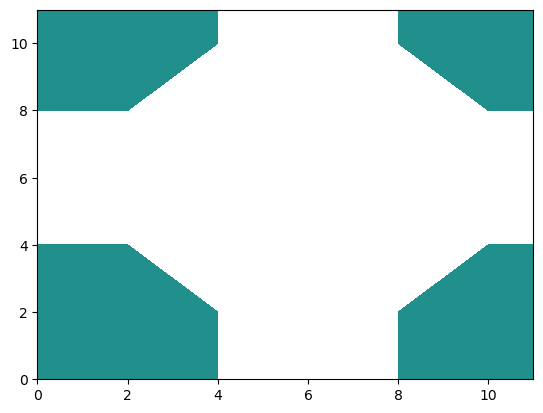

In [7]:
plt.contourf(corners())

In [10]:
def diag_mask(array):
    size = array.shape[0]
    return map2d(array, lambda _, i, j: (np.abs(i - j) > np.ceil(size/8.)))

def diag():
    size = 7
    z = np.zeros([size, size])
    a = np.where(diag_mask(z), np.random.rand(1), np.NAN)
    return(a)

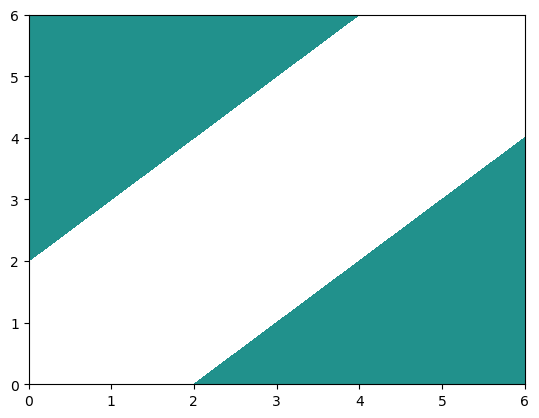

In [10]:
plt.contourf(diag())

In [11]:
def point_degree(array, i, j):
    return np.sum(np.isnan([array([i,j+1]),
                            array([i,j-1]),
                            array([i+1,j]),
                            array([i-1,j])]))

# Uses a "+"-shaped stencil for graph edges
def point_to_graph(array, i, j, imax, jmax):
    edges = []

    if not (j == jmax):
        if not np.isnan(array[i,j+1]):
            edges.append([(i,j), (i,j+1), 1.])

    if not (i == imax):
        if not np.isnan(array[i+1,j]):
            edges.append([(i,j), (i+1,j), 1.])

    return edges

def array_to_graph(array):
    graph = nx.Graph()
    imax = array.shape[0]-1
    jmax = array.shape[1]-1
    for i in range(0, array.shape[0]):
        for j in range(0,array.shape[1]):
            if not np.isnan(array[i,j]):
                graph.add_node((i,j))
                edges = point_to_graph(array, i, j, imax, jmax)
                graph.add_weighted_edges_from(edges)
            
    return graph

def mask_to_graph(mask):
    array = np.zeros(mask.shape)
    for i in range(0, array.shape[0]):
        for j in range(0,array.shape[1]):
            if not mask[i, j]:
                array[i, j] = np.nan
    return array_to_graph(array)

def array_to_subgraphs(array):
    g = array_to_graph(array)
    return [g.subgraph(sub) for sub in nx.connected_components(g)]

def mask_to_subgraphs(mask):
    g = mask_to_graph(mask)
    return [g.subgraph(sub) for sub in nx.connected_components(g)]

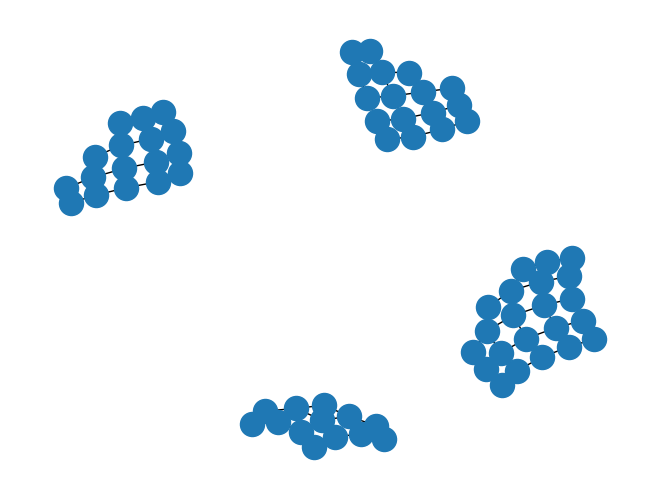

In [12]:
c = corners()
gc = array_to_graph(c)
nx.draw(gc)

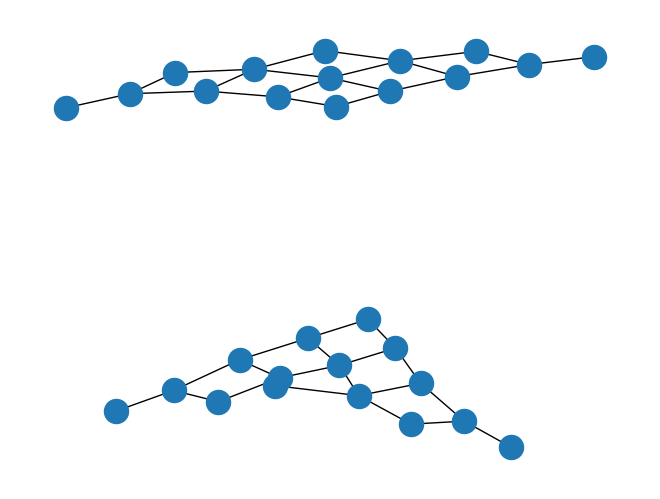

In [13]:
d = diag()
gd = array_to_graph(d)
nx.draw(gd)

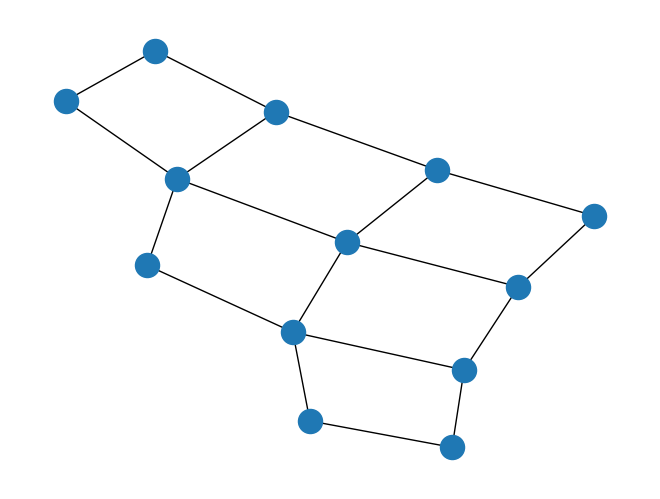

In [14]:
subgc = array_to_subgraphs(c)
subgd = array_to_subgraphs(d)
nx.draw(subgc[3])

In [15]:
def batch_to_graph(batch, sc):
    mask = batch['mask'][0].to_numpy()
    features = {x:batch[x][0].to_numpy() for x in sc.variable}
    targets  = {x:batch[x][0].to_numpy() for x in sc.target}
    features_graph = nx.Graph()
    targets_graph  = nx.Graph()
    
    
    def point_to_graph(mask, i, j, imax, jmax):
        edges = []

        if not (j == jmax):
            if mask[i, j+1]:
                edges.append([(i,j), (i,j+1), 1.])

        if not (i == imax):
            if mask[i+1,j]:
                edges.append([(i,j), (i+1,j), 1.])

        return edges
    
    imax = mask.shape[0]-1
    jmax = mask.shape[1]-1
    for i in range(0, mask.shape[0]):
        for j in range(0,mask.shape[1]):
            if mask[i, j]:
                features_ij = {x:features[x][i,j] for x in sc.variable}
                targets_ij  = {x:targets[x][i,j]  for x in sc.target}
                features_graph.add_node((i,j), **features_ij)
                targets_graph.add_node((i,j), **targets_ij)
                features_graph.add_weighted_edges_from(point_to_graph(mask, i, j, imax, jmax),)
                targets_graph.add_weighted_edges_from(point_to_graph(mask, i, j, imax, jmax),)

    return features_graph, targets_graph
    
def batch_to_subgraphs(batch, sc):
    f, t = batch_to_graph(batch, sc)
    fsub = [f.subgraph(sub) for sub in nx.connected_components(f)]
    tsub = [t.subgraph(sub) for sub in nx.connected_components(t)]
    return fsub, tsub
    